In [1]:
!!sudo apt install tesseract-ocr
!pip install pytesseract


     |████████████████████████████████| 4.3 MB 9.8 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install opencv-python

In [3]:
!pip install scikit-image

In [1]:
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt


## Resize the image and set aspect ratio

In [2]:
def resizer(image,width=500):
    # get widht and height
    h,w,c = image.shape
    
    height = int((h/w)* width )
    size = (width,height)
    image = cv2.resize(image,(width,height))
    return image

image shape (1108, 1477, 3)


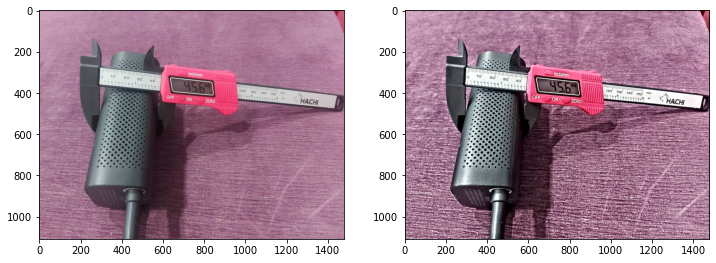

In [3]:
url = "img_vernier/626519.jpg"
url ="https://raw.githubusercontent.com/Tuchsanai/Meter_Reader/main/Digital01/img_vernier/626519.jpg"

img = io.imread(url)
detail_img= cv2.detailEnhance(img,sigma_s = 50, sigma_r = 0.15)

print('image shape',str(img.shape))

plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(detail_img)




# Find Histogram of Plastics for colror

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


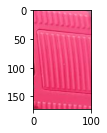

In [4]:
x = img[308:480, 852:953]
x_hsv = cv2.cvtColor(x, cv2.COLOR_RGB2HSV)

plt.subplot(2,1,1)
plt.imshow(x)
plt.subplot(2,1,1)
plt.imshow(x)

(0.0, 255.0)

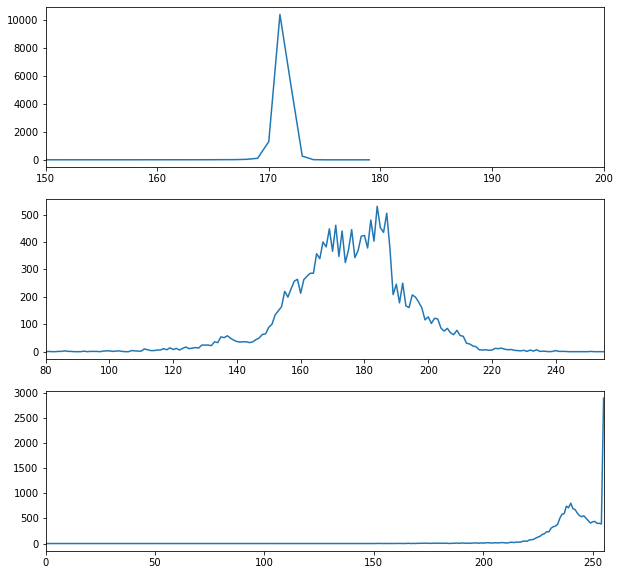

In [5]:
hist0 = cv2.calcHist([x_hsv], [0], mask = None, histSize = [180], ranges = [0, 180])
hist1 = cv2.calcHist([x_hsv], [1], mask = None, histSize = [256], ranges = [0, 256])
hist2 = cv2.calcHist([x_hsv], [2], mask = None, histSize = [256], ranges = [0, 256])

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(hist0)
plt.xlim([150, 200])
plt.subplot(3,1,2)
plt.plot(hist1)
plt.xlim([80, 255])
plt.subplot(3,1,3)
plt.plot(hist2)
plt.xlim([0, 255])


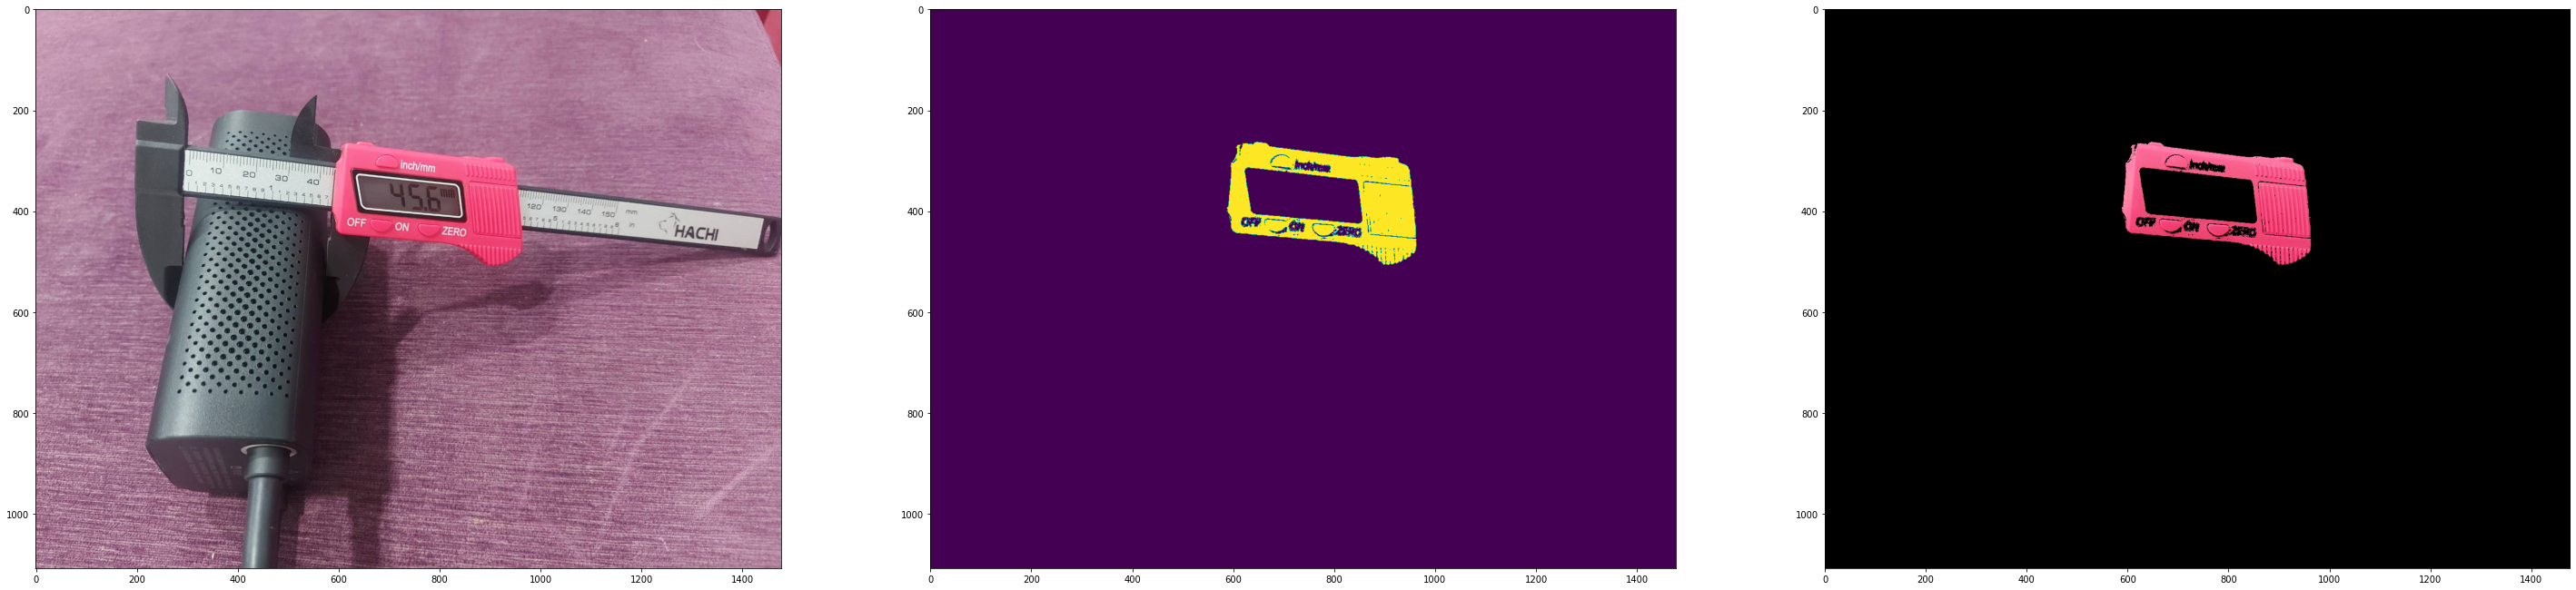

In [6]:
  
# define range of blue color in HSV
low_red = np.array([168, 100, 220], dtype=np.uint8)
high_red = np.array([175, 240,255], dtype=np.uint8)


hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Threshold the HSV image to get only blue colors
maskb = cv2.inRange(hsv, low_red, high_red)


# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= maskb)

plt.figure(figsize=(50,50))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(maskb)
plt.subplot(1,3,3)
plt.imshow(res)

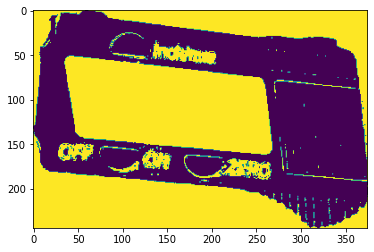

In [7]:

contour,hierarchy = cv2.findContours(maskb,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contour          = sorted(contour, key=cv2.contourArea, reverse=True)



x,y,w,h = cv2.boundingRect(contour[0])
mask1    = maskb[y:y+h,x:x+w]
imask1   = cv2.bitwise_not(mask1)
img1     = img[y:y+h,x:x+w]
plt.imshow( imask1)



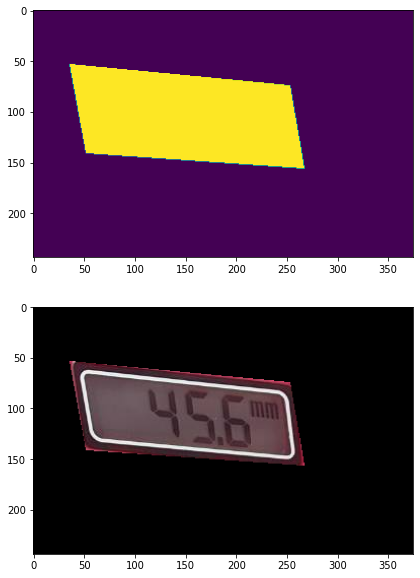

In [8]:
contour,hierarchy = cv2.findContours(imask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contour          = sorted(contour, key=cv2.contourArea, reverse=True)
for contour in contour:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.08*peri, True)
    
    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break


mask2           = cv2.fillPoly(np.zeros_like(imask1), pts =[four_points], color=(1))
img2            = cv2.bitwise_and(img1,img1,mask=mask2)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(mask2)
plt.subplot(2,1,2)
plt.imshow(img2)

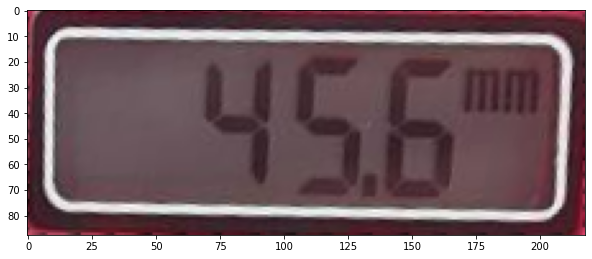

In [9]:
from imutils.perspective import four_point_transform
img3       = four_point_transform(img2,four_points)



plt.figure(figsize=(10,10))
plt.imshow(img3)

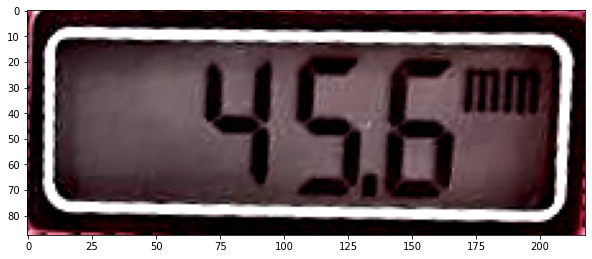

In [10]:
img4 = cv2.detailEnhance(img3,sigma_s =25 , sigma_r = 0.3)

plt.figure(figsize=(10,10))
plt.imshow(img4)

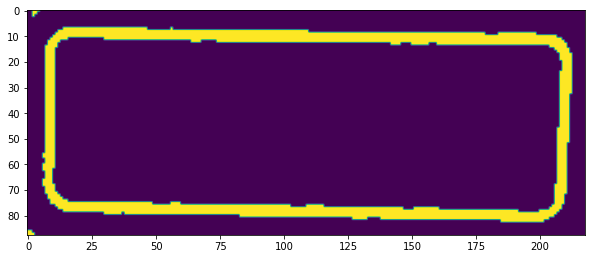

In [11]:
# Grayscale and Canny Edges extracted
gray4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
blur4 = cv2.GaussianBlur(gray4,(5,5),0)
ret4,th4 = cv2.threshold(blur4,127,255,0)


plt.figure(figsize=(10,10))
plt.imshow(th4)

In [12]:
# Find contours in template
contours, hierarchy = cv2.findContours(th4, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# We need to sort the contours by area so that we can remove the largest
# contour which is the image outline
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

four_points = None
count       = 0

for contour in sorted_contours:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.08*peri, True)
    
    if len(approx) == 4 :
        
        if count==1 :
           four_points = np.squeeze(approx)
           break
        count = count + 1


In [13]:
four_points

array([[ 10,  15],
       [203,  13],
       [206,  75],
       [ 16,  75]], dtype=int32)

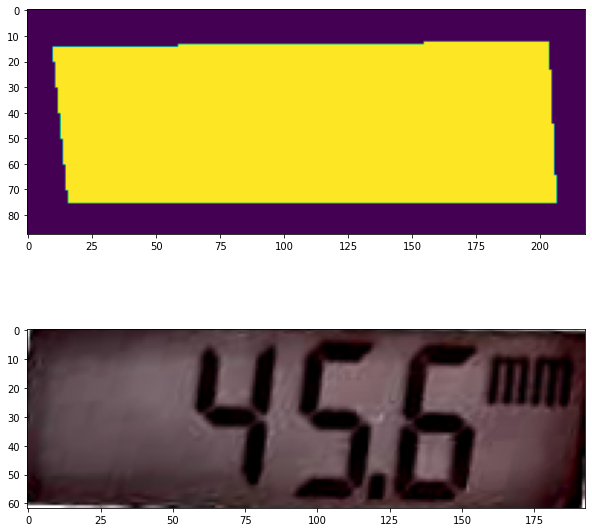

In [14]:

mask5           = cv2.fillPoly(np.zeros_like(th4), pts =[four_points], color=(1))
img5           = four_point_transform(img4,four_points)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(mask5)
plt.subplot(2,1,2)
plt.imshow(img5)

In [17]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [18]:

rgb = img5.copy()
magic_image = apply_brightness_contrast(rgb,120,0)
magic_image_c1 = apply_brightness_contrast(rgb,0,40)
magic_image_c2 = apply_brightness_contrast(rgb,120,40)

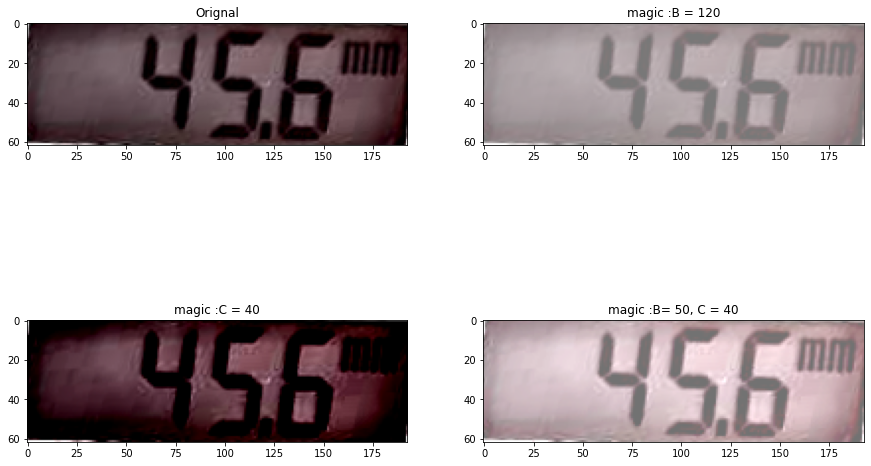

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(rgb)
plt.title('Orignal')


plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')


plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')

plt.show()

In [21]:
d = pytesseract.image_to_string( magic_image_c2 , lang='eng' )
d

'\x0c'

In [22]:
print(d)

     |████████████████████████████████| 63.6 MB 58.2 MB/s 
     |████████████████████████████████| 3.0 MB 45.8 MB/s 
     |████████████████████████████████| 47.8 MB 42 kB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [24]:
!pip install easyocr

     |████████████████████████████████| 63.6 MB 70 kB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
     |████████████████████████████████| 3.0 MB 54.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [25]:
import easyocr
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [26]:
bounds = reader.readtext( magic_image_c2)
bounds

[([[48, 0], [166, 0], [166, 62], [48, 62]], '45.61', 0.28875659369134254)]